In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# data cleaning
!pip install contractions
import contractions
import re
import string
# BERT
!pip install bert-for-tf2
from bert import bert_tokenization
# TF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 332.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=5dab617670224f8be0f162e56fe0759136005d856e487c829d46f45acfaad1ff
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=6c90b0f22d9ae7d7c3fa39c5fed115422935f614b4e3d5b6160066f678469586
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 s

In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

# Clean data

Relabel for duplicates with different target

In [3]:
duplicates = train.groupby('text').filter(lambda x: x['target'].nunique()>1 ).sort_values('text')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
duplicates

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,0
4221,5996,hazardous,NaN,#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1


In [4]:
mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
mislabeled = mislabeled[mislabeled['target'] > 1]['target']
mislabeled.index.tolist()
train.loc[train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target'] = 0
train.loc[train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target'] = 0
train.loc[train['text'] == 'To fight bioterrorism sir.', 'target'] = 0
train.loc[train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target'] = 1
train.loc[train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target'] = 1
train.loc[train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target'] = 0
train.loc[train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target'] = 0
train.loc[train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target'] = 1
train.loc[train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target'] = 1
train.loc[train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target'] = 0
train.loc[train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target'] = 0
train.loc[train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target'] = 0
train.loc[train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target'] = 0
train.loc[train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target'] = 0
train.loc[train['text'] == "Caution: breathing may be hazardous to your health.", 'target'] = 1
train.loc[train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target'] = 0
train.loc[train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target'] = 0
train.loc[train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target'] = 0

In [5]:
duplicates = train.groupby('text').filter(lambda x: x['target'].nunique()>1 ).sort_values('text')
duplicates

,id,keyword,location,text,target


Add keyword to text

In [6]:
train.keyword.fillna('', inplace=True)
# train["text"] = train["keyword"].astype(str) + ' ' + train["text"]

Clean and remove stopwords

In [7]:
def process(text):
    # lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', ' ', text)
    # remove extra whitespaces
    pattern = r'^\s*|\s\s*'
    text = re.sub(pattern, ' ', text).strip()
    
#     # expand contractions
#     text = contractions.fix(text)
#     # remove urls
#     text = re.sub('https?://\S+|www\.\S+', ' ', text)
#     # remove HTML tags
#     html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
#     text = re.sub(html, ' ', text)
#     # remove irrelevant characters - punctuations and numbers
#     #text = re.sub(r'[^a-zA-Z]', ' ', text)
#     # remove punctuations
#     #table = str.maketrans('','',string.punctuation)
#     #text = text.translate(table)
#     text = re.sub('['+string.punctuation+']', ' ', text)

#     # remove non-ASCII characters
#     text = re.sub(r'[^\x00-\x7f]',r' ', text)
#     # remove newline \n
#     text = re.sub('\n', ' ', text)
    
    
    return text

In [8]:
# df = pd.concat([train, test])
# df['text'] = df['text'].apply(lambda x: process(x))
# train = df[:7613]
# test = df[7613:]
# test = test.drop('target', axis=1)

In [9]:
train.tail()

,id,keyword,location,text,target
7608,10869,,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1
7612,10873,,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1


In [10]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Relabel for duplicates with different target

In [11]:
duplicates = train.groupby('text').filter(lambda x: x['target'].nunique()>1 ).sort_values('text')
duplicates

,id,keyword,location,text,target


In [12]:
# train = train.drop_duplicates(subset=['text'], keep=False)

In [13]:
# mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
# mislabeled = mislabeled[mislabeled['target'] > 1]['target']
# mislabeled.index.tolist()

In [14]:
# train.loc[train['text'] == 'that horrible sinking feeling when you\x89ûªve been at home on your phone for a while and you realise its been on g this whole time', 'target'] = 0
# train.loc[train['text'] == 'one direction is my pick for http://t.co/q eblokeve fan army #directioners http://t.co/encmhz y x', 'target'] = 0

In [15]:
duplicates = train.groupby('text').filter(lambda x: x['target'].nunique()>1 ).sort_values('text')
duplicates

,id,keyword,location,text,target


# K-Fold Cross Validation

In [16]:
kf = StratifiedKFold(n_splits=5, random_state=1337, shuffle=True)

# Load BERT and encode text

In [17]:
def get_bert_layer():
    m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
    bert_layer = hub.KerasLayer(m_url, trainable=True)

    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)
    
    return bert_layer, tokenizer

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.4)(clf_output)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
#     out = tf.keras.layers.Dense(1, activation='sigmoid')(clf_output)
    
#     x = tf.keras.layers.Dense(6, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(clf_output)
#     x = tf.keras.layers.Dropout(0.5)(x)
#     out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',
#                   metrics=['accuracy', tfa.metrics.F1Score(1, threshold=0.5)])
    
    return model

# Model


Fold 0

Epoch 1/10
191/191 [==============================] - 64s 266ms/step - loss: 0.4875 - accuracy: 0.7662 - val_loss: 0.4033 - val_accuracy: 0.8332

Epoch 00001: val_accuracy improved from -inf to 0.83322, saving model to model_0.h5
Epoch 2/10
191/191 [==============================] - 50s 263ms/step - loss: 0.3580 - accuracy: 0.8498 - val_loss: 0.3955 - val_accuracy: 0.8411

Epoch 00002: val_accuracy improved from 0.83322 to 0.84110, saving model to model_0.h5
Epoch 3/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2934 - accuracy: 0.8824 - val_loss: 0.4033 - val_accuracy: 0.8424

Epoch 00003: val_accuracy improved from 0.84110 to 0.84242, saving model to model_0.h5
Epoch 4/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2458 - accuracy: 0.9074 - val_loss: 0.4356 - val_accuracy: 0.8365

Epoch 00004: val_accuracy did not improve from 0.84242
Epoch 5/10
191/191 [==============================] - 50s 263ms/step - loss: 0.1879 - accuracy

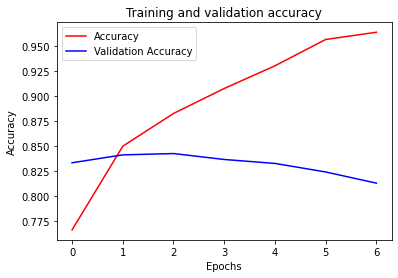

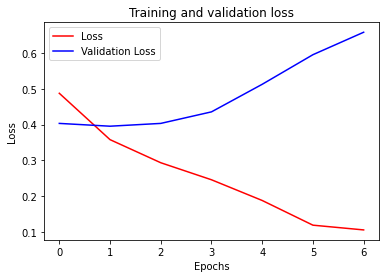


Fold 1

Epoch 1/10
191/191 [==============================] - 63s 266ms/step - loss: 0.4694 - accuracy: 0.7808 - val_loss: 0.4030 - val_accuracy: 0.8253

Epoch 00001: val_accuracy improved from -inf to 0.82534, saving model to model_1.h5
Epoch 2/10
191/191 [==============================] - 50s 264ms/step - loss: 0.3487 - accuracy: 0.8604 - val_loss: 0.3903 - val_accuracy: 0.8293

Epoch 00002: val_accuracy improved from 0.82534 to 0.82928, saving model to model_1.h5
Epoch 3/10
191/191 [==============================] - 50s 262ms/step - loss: 0.2851 - accuracy: 0.8913 - val_loss: 0.4481 - val_accuracy: 0.8227

Epoch 00003: val_accuracy did not improve from 0.82928
Epoch 4/10
191/191 [==============================] - 50s 262ms/step - loss: 0.2290 - accuracy: 0.9166 - val_loss: 0.4628 - val_accuracy: 0.8201

Epoch 00004: val_accuracy did not improve from 0.82928

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
Epoch 5/10
191/191 [========================

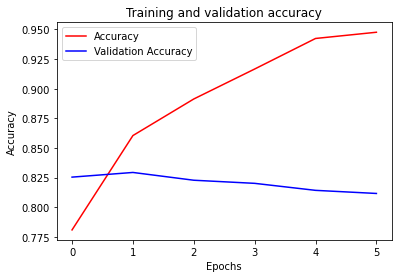

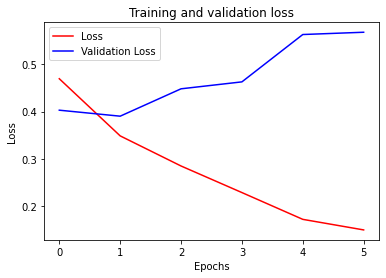


Fold 2

Epoch 1/10
191/191 [==============================] - 62s 266ms/step - loss: 0.4859 - accuracy: 0.7644 - val_loss: 0.3676 - val_accuracy: 0.8523

Epoch 00001: val_accuracy improved from -inf to 0.85227, saving model to model_2.h5
Epoch 2/10
191/191 [==============================] - 50s 263ms/step - loss: 0.3557 - accuracy: 0.8530 - val_loss: 0.3649 - val_accuracy: 0.8569

Epoch 00002: val_accuracy improved from 0.85227 to 0.85686, saving model to model_2.h5
Epoch 3/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2850 - accuracy: 0.8921 - val_loss: 0.4042 - val_accuracy: 0.8293

Epoch 00003: val_accuracy did not improve from 0.85686
Epoch 4/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2272 - accuracy: 0.9108 - val_loss: 0.4472 - val_accuracy: 0.8437

Epoch 00004: val_accuracy did not improve from 0.85686

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
Epoch 5/10
191/191 [========================

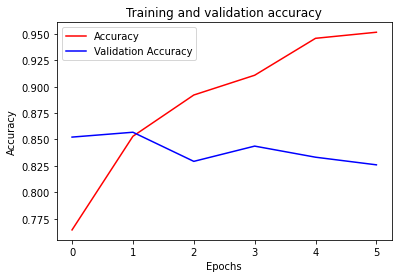

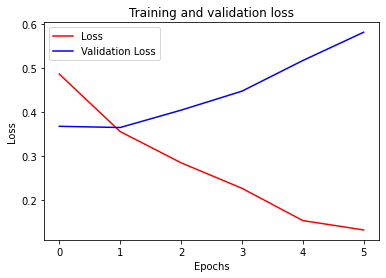


Fold 3

Epoch 1/10
191/191 [==============================] - 63s 266ms/step - loss: 0.4674 - accuracy: 0.7903 - val_loss: 0.4040 - val_accuracy: 0.8226

Epoch 00001: val_accuracy improved from -inf to 0.82260, saving model to model_3.h5
Epoch 2/10
191/191 [==============================] - 50s 263ms/step - loss: 0.3532 - accuracy: 0.8577 - val_loss: 0.4028 - val_accuracy: 0.8384

Epoch 00002: val_accuracy improved from 0.82260 to 0.83837, saving model to model_3.h5
Epoch 3/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2948 - accuracy: 0.8823 - val_loss: 0.4517 - val_accuracy: 0.8279

Epoch 00003: val_accuracy did not improve from 0.83837
Epoch 4/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2350 - accuracy: 0.9105 - val_loss: 0.5131 - val_accuracy: 0.8318

Epoch 00004: val_accuracy did not improve from 0.83837

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
Epoch 5/10
191/191 [========================

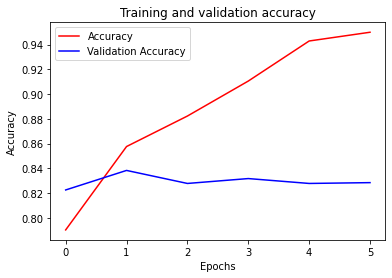

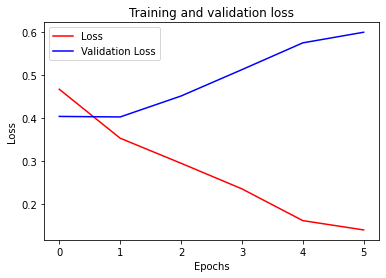


Fold 4

Epoch 1/10
191/191 [==============================] - 63s 267ms/step - loss: 0.4998 - accuracy: 0.7651 - val_loss: 0.3617 - val_accuracy: 0.8476

Epoch 00001: val_accuracy improved from -inf to 0.84757, saving model to model_4.h5
Epoch 2/10
191/191 [==============================] - 50s 263ms/step - loss: 0.3674 - accuracy: 0.8488 - val_loss: 0.3476 - val_accuracy: 0.8555

Epoch 00002: val_accuracy improved from 0.84757 to 0.85545, saving model to model_4.h5
Epoch 3/10
191/191 [==============================] - 50s 264ms/step - loss: 0.3086 - accuracy: 0.8759 - val_loss: 0.3630 - val_accuracy: 0.8555

Epoch 00003: val_accuracy did not improve from 0.85545
Epoch 4/10
191/191 [==============================] - 50s 263ms/step - loss: 0.2443 - accuracy: 0.9072 - val_loss: 0.4610 - val_accuracy: 0.8456

Epoch 00004: val_accuracy did not improve from 0.85545

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
Epoch 5/10
191/191 [========================

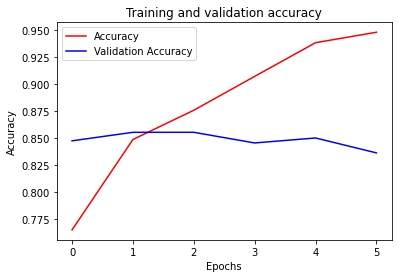

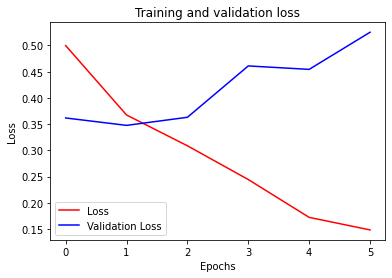

Average Max Accuracy:  0.8444772005081177


In [18]:
accuracies = []
# f1s = []
models = []
max_len = 64

for fold, (train_index, val_index) in enumerate(kf.split(train.text.values, train.keyword.values)):
    # stratifcation based on keyword
    print('\nFold {}\n'.format(fold))
    
    train_df = train.iloc[train_index]
    val_df = train.iloc[val_index]
    
    bert_layer, tokenizer = get_bert_layer()
    x_train = bert_encode(train_df.text.values, tokenizer, max_len=max_len)
    x_valid = bert_encode(val_df.text.values, tokenizer, max_len=max_len)
    y_train = train_df.target.values
    y_valid = val_df.target.values
    
    model = build_model(bert_layer, max_len=max_len)
    
    # val accuracy
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model_{fold}.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.2, verbose=1)
    callbacks = [checkpoint, early_stopping, reduce_lr]
#     # f1
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model_{fold}.h5', monitor='val_f1_score', save_best_only=True, verbose=1)
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=4, verbose=1)
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', patience=2, factor=0.2, verbose=1)
#     callbacks = [checkpoint, early_stopping, reduce_lr]

    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, callbacks=callbacks, verbose=1)
    # , batch_size=16
    accuracies.append(max(history.history['val_accuracy']))
#     f1s.append(max(history.history['val_f1_score']))
    
    # plot accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])
    plt.show()
    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])
    plt.show()
    
    model.load_weights(f'model_{fold}.h5')
    models.append(model)
    
print("Average Max Accuracy: ", np.mean(accuracies))
# print("Average Max F1: ", np.mean(f1s))

In [19]:
# print(accuracies)
# print(f1s)

# Predict and submit

In [20]:
soft_voting = pd.DataFrame()
x_test = bert_encode(test.text.values, tokenizer, max_len=max_len)
for n, m in enumerate(models):
    test_prob = m.predict(x_test)
    soft_voting[n] = test_prob.flatten()

In [21]:
soft_voting[5] = (soft_voting[0]+soft_voting[1]+soft_voting[2]+soft_voting[3]+soft_voting[4])/5
submission['target'] = soft_voting[5].values.round().astype(int)
submission.to_csv('submission.csv', index=False)